In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
from prettytable import PrettyTable

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
kanada_data = pd.read_csv("kn_train.csv")
kanada_val = pd.read_csv("kn_val.csv")
kanada_test = pd.read_csv("Kannada_Test_Set_No_Labels.csv")
kanada_data = pd.concat([kanada_data, kanada_val], axis=0)

tamil_data = pd.read_csv("tamil_train.csv")
tamil_val = pd.read_csv("tamil_val.csv")
tamil_test = pd.read_csv("Tamil_Test_Set_No_Labels.csv")
tamil_data = pd.concat([tamil_data, tamil_val], axis=0)

tulu_data = pd.read_csv("tulu_train.csv")
tulu_val = pd.read_csv("tulu_val.csv")
tulu_test = pd.read_csv("Tulu_Test_Set_No_Labels.csv")
tulu_data = pd.concat([tulu_data, tulu_val], axis=0)

malayalam_data = pd.read_csv("mal_train.csv")
malayalam_val = pd.read_csv("mal_val.csv")
malayalam_test = pd.read_csv("Malayalam_Test_Set_No_Labels.csv")
malayalam_data = pd.concat([malayalam_data, malayalam_val], axis=0)

In [3]:
# Removing wrong data in the "sym" category and changing "*" symbol to "asterisk" word for Better Vectorization
kanada_data = kanada_data[~((kanada_data["Word"] == "and") & (kanada_data["Tag"] == "sym"))].replace("*", "asterisk").fillna("")

# Oversampling "other", "mixed" and "kn" categories to improve accuracy of those categories
kanada_other = kanada_data[kanada_data["Tag"] == "other"]
kn = kanada_data[kanada_data["Tag"] == "kn"]
tulu_kn = tulu_data[tulu_data["Language"] == "Kannada"]
tulu_kn.columns = ["Word", "Tag"]
tulu_kn["Tag"] = tulu_kn["Tag"].replace("Kannada", "kn")
kn_mixed = kanada_data[kanada_data["Tag"] == "mixed"]

# Names from other languages are also included (More the data, Better the performance)
tamil_name = tamil_data[tamil_data["Tag"] == "name"]
kanada_name = kanada_data[kanada_data["Tag"] == "name"]
tulu_name = tulu_data[tulu_data["Language"] == "Name"]
tulu_name.columns = ["Word", "Tag"]
tulu_name["Tag"] = tulu_name["Tag"].replace("Name", "name")
malayalam_name = malayalam_data[malayalam_data["Tag"] == "NAME"]
malayalam_name["Tag"] = malayalam_name["Tag"].replace("NAME", "name")

# Locations from other languages are also included
tamil_loc = tamil_data[tamil_data["Tag"] == "Location"]
tamil_loc["Tag"] = tamil_loc["Tag"].replace("Location", "location")
kanada_loc = kanada_data[kanada_data["Tag"] == "location"]
tulu_loc = tulu_data[tulu_data["Language"] == "Location"]
tulu_loc.columns = ["Word", "Tag"]
tulu_loc["Tag"] = tulu_loc["Tag"].replace("Location", "location")
malayalam_loc = malayalam_data[malayalam_data["Tag"] == "PLACE"]
malayalam_loc["Tag"] = malayalam_loc["Tag"].replace("PLACE", "location")

# Combining all the data needed for training
kanada_data = pd.concat([kanada_data, tulu_kn, kanada_loc, kanada_name, tulu_name, kn_mixed, tamil_name, kanada_other, tulu_loc, kn, tamil_loc, malayalam_loc, kn_mixed, malayalam_name]).fillna("")

C:\Users\justa\AppData\Local\Temp\ipykernel_22220\3075093012.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tulu_kn["Tag"] = tulu_kn["Tag"].replace("Kannada", "kn")
C:\Users\justa\AppData\Local\Temp\ipykernel_22220\3075093012.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tulu_name["Tag"] = tulu_name["Tag"].replace("Name", "name")
C:\Users\justa\AppData\Local\Temp\ipykernel_22220\3075093012.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [4]:
kanada_data.describe()

,Word,Tag
count,52385,52385
unique,10453,7
top,asterisk,en
freq,4070,18777


<Axes: xlabel='Tag', ylabel='Count'>

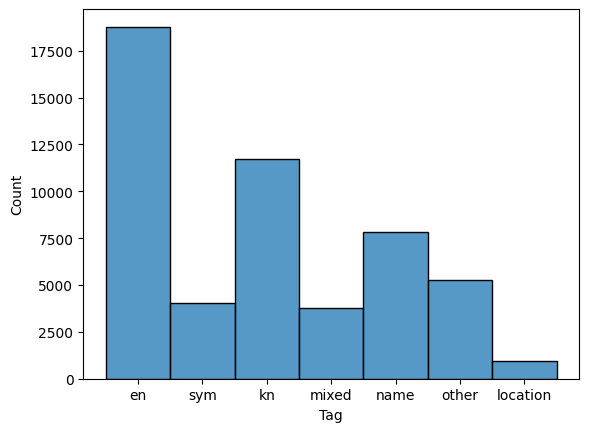

In [5]:
sb.histplot(kanada_data["Tag"])

In [6]:
countVectorizer = CountVectorizer(ngram_range=(1,5), analyzer='char')

kf = KFold(n_splits=10, shuffle=True, random_state=42)

model1 = DecisionTreeClassifier(random_state=42)

model2 = LogisticRegression(solver='newton-cg', max_iter=2000)

model3 = svm.SVC()

model7 = VotingClassifier(
    estimators=[
        ('dtc', model1), 
        ('lr', model2), 
        ('svm', model3),
    ],
    voting='hard'
)

acc = [[], [], []] 
f1 = [[], [], []]
pre = [[], [], []]
rec = [[], [], []]

f1_a = [[], [], []]

In [7]:
X = kanada_data["Word"]
Y = kanada_data["Tag"]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    

    train_vect_count = countVectorizer.fit_transform(X_train)
    test_vect_count = countVectorizer.transform(X_test)

    # DECISION TREE CLASSIFIER MODEL
    model1.fit(train_vect_count, y_train)
    model1_predict = model1.predict(test_vect_count)

    acc[0].append(accuracy_score(y_test, model1_predict))
    f1[0].append(f1_score(y_test, model1_predict, average='macro'))
    f1_a[0].append(f1_score(y_test, model1_predict, average='weighted'))
    pre[0].append(precision_score(y_test, model1_predict, average='macro', zero_division=np.nan))
    rec[0].append(recall_score(y_test, model1_predict, average='macro', zero_division=np.nan))


    # LOGISTIC REGRESSION MODEL
    model2.fit(train_vect_count, y_train)
    model2_predict = model2.predict(test_vect_count)

    acc[1].append(accuracy_score(y_test, model2_predict))
    f1[1].append(f1_score(y_test, model2_predict, average='macro'))
    f1_a[1].append(f1_score(y_test, model2_predict, average='weighted'))
    pre[1].append(precision_score(y_test, model2_predict, average="macro", zero_division=np.nan))
    rec[1].append(recall_score(y_test, model2_predict, average="macro", zero_division=np.nan))

    # SUPPORT VECTOR MACHINE MODEL
    model3.fit(train_vect_count, y_train)
    model3_predict = model3.predict(test_vect_count)

    acc[2].append(accuracy_score(y_test, model3_predict))
    f1[2].append(f1_score(y_test, model3_predict, average="macro"))
    f1_a[2].append(f1_score(y_test, model3_predict, average="weighted"))
    pre[2].append(precision_score(y_test, model3_predict, average="macro", zero_division=np.nan))
    rec[2].append(recall_score(y_test, model3_predict, average="macro", zero_division=np.nan))

In [8]:
DTC = ["Decision Tree Classifier",sum(acc[0])/len(acc[0]), sum(f1[0])/len(f1[0]), sum(f1_a[0])/len(f1_a[0]),sum(pre[0])/len(pre[0]), sum(rec[0])/len(rec[0])]
Logistic = ["Logistic Regression", sum(acc[1])/len(acc[1]), sum(f1[1])/len(f1[1]), sum(f1_a[1])/len(f1_a[1]), sum(pre[1])/len(pre[1]), sum(rec[1])/len(rec[1])]
SVM = ["Support Vector Machine",sum(acc[2])/len(acc[2]), sum(f1[2])/len(f1[2]), sum(f1_a[2])/len(f1_a[2]), sum(pre[2])/len(pre[2]), sum(rec[2])/len(rec[2])]

fields = ["Model Name", "Accuracy", "F1 Score (Macro)", "F1 Score (Weighted)", "Precision", "Recall Score"]

table = PrettyTable(field_names=fields)
table.add_rows([DTC, Logistic, SVM])
table

Model Name,Accuracy,F1 Score (Macro),F1 Score (Weighted),Precision,Recall Score
Decision Tree Classifier,0.9525435828344426,0.943472996097498,0.9524164339286629,0.9445857062234179,0.9432625997979203
Logistic Regression,0.958938530527899,0.9511064826837863,0.9587376274508855,0.9551628973353552,0.9475618667529441
Support Vector Machine,0.9453849338758908,0.9352188218820473,0.944835482154906,0.9496513156367257,0.9230310420788204


In [9]:
x_train = kanada_data["Word"]
y_train = kanada_data["Tag"]
x_test = kanada_val["Word"].replace("*", "asterisk").fillna("")
y_test = kanada_val["Tag"]

count_vec_train = countVectorizer.fit_transform(x_train)
count_vec_test = countVectorizer.transform(x_test)

model7.fit(count_vec_train, y_train)
model7_predict = model7.predict(count_vec_test)

print(classification_report(y_test, model7_predict), "\n")

              precision    recall  f1-score   support

          en       1.00      0.99      1.00      1109
          kn       0.99      0.99      0.99       637
    location       1.00      0.92      0.96        13
       mixed       0.98      0.99      0.99       180
        name       0.97      1.00      0.98       158
       other       0.96      0.94      0.95        53
         sym       1.00      1.00      1.00       334

    accuracy                           0.99      2484
   macro avg       0.99      0.98      0.98      2484
weighted avg       0.99      0.99      0.99      2484
 



In [10]:
x_train = kanada_data["Word"]
y_train = kanada_data["Tag"]
final_test = pd.read_csv("Kannada_Test_Set_No_Labels.csv")
x_test = final_test["Word"].replace("*", "asterisk").fillna("")

count_vec_train = countVectorizer.fit_transform(x_train)
count_vec_test = countVectorizer.transform(x_test)

model7.fit(count_vec_train, y_train)
pred = model7.predict(count_vec_test)

result = pd.concat([final_test.reset_index(drop=True), pd.Series(pred, name="Tag")], axis=1)
result.to_csv('predictions.csv', index=False)

In [11]:
ans = pd.read_csv("predictions.csv")
ans["Tag"].value_counts()

Tag
en          1290
kn           618
sym          306
name         124
other         81
mixed         66
location      17
Name: count, dtype: int64